- Try to peak analysis instead to filter the neurons
- First filter by comparison with spike shuffle data
- Separate track into outbound and homebound zone
- Use new ramp score
- Only perform analysis on Sarah's cell
- Use coefficient-based ramp score

In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import os
os.environ['MPLCONFIGDIR'] = '../config'
import pickle
import pandas as pd
import sklearn as sk
from sklearn.decomposition import *
from sklearn.cluster import *
import numpy as np
import matplotlib.pylab as plt
from matplotlib.backends.backend_pdf import PdfPages
from analysis.sparse_analysis import *
import sklearn.metrics as skmetrics
from scipy.stats import pearsonr, wilcoxon
from scipy import signal
from palettable.colorbrewer.qualitative import Paired_8 as colors
np.random.seed(0) #for reproducibility
import matplotlib as mpl
from analysis.peak_detect import *
import pickle
import pandas as pd 
import seaborn as sns
sns.set_palette("Accent")
import matplotlib as mpl

/home/teristam/miniconda3/envs/glm_mec_model/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data

In [2]:
# clean up the classification dataframe
output_path = '/mnt/datastore/Teris/CurrentBiology_2022/'
df_lm= pd.read_csv(output_path+'all_results_coefficients.csv',sep='\t')
totalNumCell = len(df_lm.unique_id.unique())
print(f'Total number of cells {totalNumCell}')
df_lm.rename(columns={'index   session_id':'session_id'}, inplace=True)
df_lm = df_lm.melt(id_vars=['session_id','cluster_id','unique_id'],var_name='trial_type_str',value_name='value')

Total number of cells 1456


### Separate the data into two set, one for slope and another for classification to clean up the data

In [3]:
df_lm_fit = df_lm[df_lm.trial_type_str.str.contains('asr')].reset_index(drop=True)

def parse_trial_type(x):
    
    if '_o_' in x:
        region = 'outbound'
    elif '_h_' in x:
        region = 'homebound'
    
    if '_b' in x:
        trial_type = 'beaconed'
    elif '_nb' in x:
        trial_type = 'non-beaconed'
    else:
        trial_type = 'probe'
        
    if 'r.squared' in x:
        fit_var='r.squared'
    elif 'intercept' in x:
        fit_var = 'intercept'
    elif 'p.value' in x:
        fit_var = 'p.value'
    else:
        fit_var='slope'
        
    return {'trial_type': trial_type, 'region':region, 'fit_var':fit_var}

# prase the type type string and convert them to indicator variables
trial_type = pd.DataFrame(df_lm_fit.trial_type_str.apply(parse_trial_type).tolist()) # return Series inside function is expensive
df_lm_fit= pd.concat([df_lm_fit, trial_type], axis=1)

# covert the r.squared and slope into their respective columns
df_lm_fit=df_lm_fit.pivot_table(index=['session_id','cluster_id','unique_id','region','trial_type'], columns='fit_var',values='value')
df_lm_fit.reset_index(inplace=True)
df_lm_fit

fit_var,session_id,cluster_id,unique_id,region,trial_type,intercept,p.value,r.squared,slope
0,245_D13_2018-11-03_11-14-27,5,245_D13_2018-11-03_11-14-27_5,homebound,beaconed,8.207059,5.886582e-01,0.004986,0.014954
1,245_D13_2018-11-03_11-14-27,5,245_D13_2018-11-03_11-14-27_5,homebound,probe,19.526991,2.782940e-01,0.019891,-0.057477
2,245_D13_2018-11-03_11-14-27,5,245_D13_2018-11-03_11-14-27_5,outbound,beaconed,13.308993,1.530610e-03,0.157701,-0.063834
3,245_D13_2018-11-03_11-14-27,5,245_D13_2018-11-03_11-14-27_5,outbound,probe,12.847300,1.767696e-01,0.030706,-0.058100
4,245_D13_2018-11-03_11-14-27,7,245_D13_2018-11-03_11-14-27_7,homebound,beaconed,76.540240,5.924664e-03,0.121411,-0.167211
...,...,...,...,...,...,...,...,...,...
7051,M7_D9_2020-11-08_16-29-26,30,M7_D9_2020-11-08_16-29-26_30,outbound,non-beaconed,21.391100,1.218631e-01,0.040082,0.124213
7052,M7_D9_2020-11-08_16-29-26,32,M7_D9_2020-11-08_16-29-26_32,homebound,beaconed,-22.422907,3.521046e-15,0.652908,0.282539
7053,M7_D9_2020-11-08_16-29-26,32,M7_D9_2020-11-08_16-29-26_32,homebound,non-beaconed,-11.477326,6.204354e-06,0.294628,0.185048
7054,M7_D9_2020-11-08_16-29-26,32,M7_D9_2020-11-08_16-29-26_32,outbound,beaconed,3.656932,1.894179e-02,0.089831,0.018598


In [4]:
df_lm_cls = df_lm[df_lm.trial_type_str.str.contains('lm_group')].reset_index(drop=True)
df_lm_cls.rename(columns={'value':'classification'}, inplace=True)

def parse_trial_type_cls(x):
    
    if '_h' in x:
        region = 'homebound'
    else:
        region = 'outbound'
    
    if '_b' in x:
        trial_type = 'beaconed'
    elif '_nb' in x:
        trial_type = 'non-beaconed'
    elif '_p' in x:
        trial_type = 'probe'
        
    return {'trial_type': trial_type, 'region':region}

trial_type = pd.DataFrame(df_lm_cls.trial_type_str.apply(parse_trial_type_cls).tolist())

df_lm_cls = pd.concat([df_lm_cls, trial_type], axis=1).drop(columns='trial_type_str')
df_lm_cls                     

,session_id,cluster_id,unique_id,classification,trial_type,region
0,245_D18_2018-11-10_11-07-50,9,245_D18_2018-11-10_11-07-50_9,Unclassified,beaconed,outbound
1,245_D18_2018-11-10_11-07-50,13,245_D18_2018-11-10_11-07-50_13,Positive,beaconed,outbound
2,245_D25_2018-11-19_11-03-26,7,245_D25_2018-11-19_11-03-26_7,Unclassified,beaconed,outbound
3,245_D25_2018-11-19_11-03-26,9,245_D25_2018-11-19_11-03-26_9,Unclassified,beaconed,outbound
4,245_D25_2018-11-19_11-03-26,16,245_D25_2018-11-19_11-03-26_16,Negative,beaconed,outbound
...,...,...,...,...,...,...
8731,M7_D6_2020-11-05_16-26-28,16,M7_D6_2020-11-05_16-26-28_16,Unclassified,probe,homebound
8732,M7_D6_2020-11-05_16-26-28,20,M7_D6_2020-11-05_16-26-28_20,Unclassified,probe,homebound
8733,M7_D6_2020-11-05_16-26-28,26,M7_D6_2020-11-05_16-26-28_26,Unclassified,probe,homebound
8734,M7_D6_2020-11-05_16-26-28,30,M7_D6_2020-11-05_16-26-28_30,Unclassified,probe,homebound


In [5]:
# Merge the two columns together
df_lm_merged = df_lm_cls.merge(df_lm_fit,on=['session_id','cluster_id','unique_id','trial_type','region'])
df_lm_merged

,session_id,cluster_id,unique_id,classification,trial_type,region,intercept,p.value,r.squared,slope
0,245_D18_2018-11-10_11-07-50,9,245_D18_2018-11-10_11-07-50_9,Unclassified,beaconed,outbound,8.564640,6.342470e-01,0.003862,0.008569
1,245_D18_2018-11-10_11-07-50,13,245_D18_2018-11-10_11-07-50_13,Positive,beaconed,outbound,21.115878,1.095253e-07,0.382349,0.257196
2,245_D25_2018-11-19_11-03-26,7,245_D25_2018-11-19_11-03-26_7,Unclassified,beaconed,outbound,59.212074,5.639698e-03,0.122744,-0.067836
3,245_D25_2018-11-19_11-03-26,9,245_D25_2018-11-19_11-03-26_9,Unclassified,beaconed,outbound,15.507494,2.521485e-01,0.022166,-0.015054
4,245_D25_2018-11-19_11-03-26,16,245_D25_2018-11-19_11-03-26_16,Negative,beaconed,outbound,28.202687,2.114192e-14,0.631363,-0.155470
...,...,...,...,...,...,...,...,...,...,...
7051,M6_D8_2020-11-07_15-49-19,29,M6_D8_2020-11-07_15-49-19_29,Unclassified,probe,homebound,12.788503,4.767406e-01,0.008617,0.083180
7052,M6_D8_2020-11-07_15-49-19,30,M6_D8_2020-11-07_15-49-19_30,Unclassified,probe,homebound,33.648082,6.108315e-01,0.004417,-0.045614
7053,M6_D8_2020-11-07_15-49-19,33,M6_D8_2020-11-07_15-49-19_33,Unclassified,probe,homebound,31.538959,1.473791e-01,0.035245,-0.119551
7054,M4_D12_2020-11-13_15-08-51,3,M4_D12_2020-11-13_15-08-51_3,Unclassified,probe,homebound,5.149499,6.807392e-01,0.002890,-0.017358


In [6]:
# sanity check
print(np.sum(((df_lm_merged['classification']=='Negative') & (df_lm_merged['slope']>0))))
print(np.sum(((df_lm_merged['classification']=='Positive') & (df_lm_merged['slope']<0))))

0
0


### Merge with ramp score

In [7]:
with open(output_path + "all_rampscore.pkl",'rb') as f:
    df_ramp_score = pickle.load(f)
df_ramp_score.rename(columns={'ramp_region':'region','score':'ramp_score'}, inplace=True) #align the column names before merge

df_all = df_ramp_score.merge(df_lm_merged,on=['session_id','cluster_id','trial_type','region'], indicator=True)

# Make sure everything is matched
missing=df_all[df_all._merge=='left_only'].unique_id.unique()
assert len(missing) ==0, f'Missing {missing}'

df_all.to_pickle(output_path + 'df_lm_merge.pkl')
df_all


,ramp_score,breakpoint,cluster_id,fr_smooth,region,pos_bin,trial_type,session_id,unique_id,classification,intercept,p.value,r.squared,slope,_merge
0,-0.182536,"[30, 42]",9,"[43.68458054070015, 42.56785787535457, 41.4511...",outbound,"[30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 5...",beaconed,245_D18_2018-11-10_11-07-50,245_D18_2018-11-10_11-07-50_9,Unclassified,8.564640,0.634247,0.003862,0.008569,both
1,NaN,NaN,9,NaN,outbound,NaN,non-beaconed,245_D18_2018-11-10_11-07-50,245_D18_2018-11-10_11-07-50_9,Unclassified,9.159867,0.777074,0.001369,-0.016275,both
2,-0.353182,"[30, 44]",9,"[49.581377575673685, 45.40426993758403, 41.227...",outbound,"[30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 5...",probe,245_D18_2018-11-10_11-07-50,245_D18_2018-11-10_11-07-50_9,Unclassified,1.112067,0.028414,0.078811,0.135426,both
3,0.388619,"[120, 148]",9,"[42.92607260106132, 41.19938350855869, 39.4726...",homebound,"[110, 112, 114, 116, 118, 120, 122, 124, 126, ...",beaconed,245_D18_2018-11-10_11-07-50,245_D18_2018-11-10_11-07-50_9,Unclassified,7.370776,0.295953,0.018498,0.020123,both
4,NaN,NaN,9,NaN,homebound,NaN,non-beaconed,245_D18_2018-11-10_11-07-50,245_D18_2018-11-10_11-07-50_9,Unclassified,2.670541,0.550753,0.006066,0.056332,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7051,-0.296264,"[110, 154]",30,"[97.18531664143444, 97.83924111326434, 98.4931...",homebound,"[110, 112, 114, 116, 118, 120, 122, 124, 126, ...",non-beaconed,M7_D6_2020-11-05_16-26-28,M7_D6_2020-11-05_16-26-28_30,Negative,42.146282,0.000462,0.189077,-0.164199,both
7052,0.289442,"[30, 60]",31,"[48.071424741044986, 48.678930574592805, 49.28...",outbound,"[30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 5...",beaconed,M7_D6_2020-11-05_16-26-28,M7_D6_2020-11-05_16-26-28_31,Unclassified,11.228872,0.015118,0.095967,0.040422,both
7053,0.266726,"[30, 52]",31,"[50.60197916818517, 52.756960225496826, 54.911...",outbound,"[30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 5...",non-beaconed,M7_D6_2020-11-05_16-26-28,M7_D6_2020-11-05_16-26-28_31,Unclassified,14.342872,0.887315,0.000343,0.004639,both
7054,0.262566,"[116, 138]",31,"[60.704952549339374, 60.65759676349667, 60.610...",homebound,"[110, 112, 114, 116, 118, 120, 122, 124, 126, ...",beaconed,M7_D6_2020-11-05_16-26-28,M7_D6_2020-11-05_16-26-28_31,Positive,6.097249,0.000895,0.171841,0.074008,both


In [8]:
np.mean(df_all.ramp_score.isna())

0.0005668934240362812

### Plot

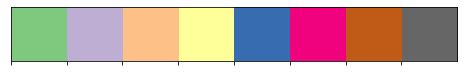

In [9]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

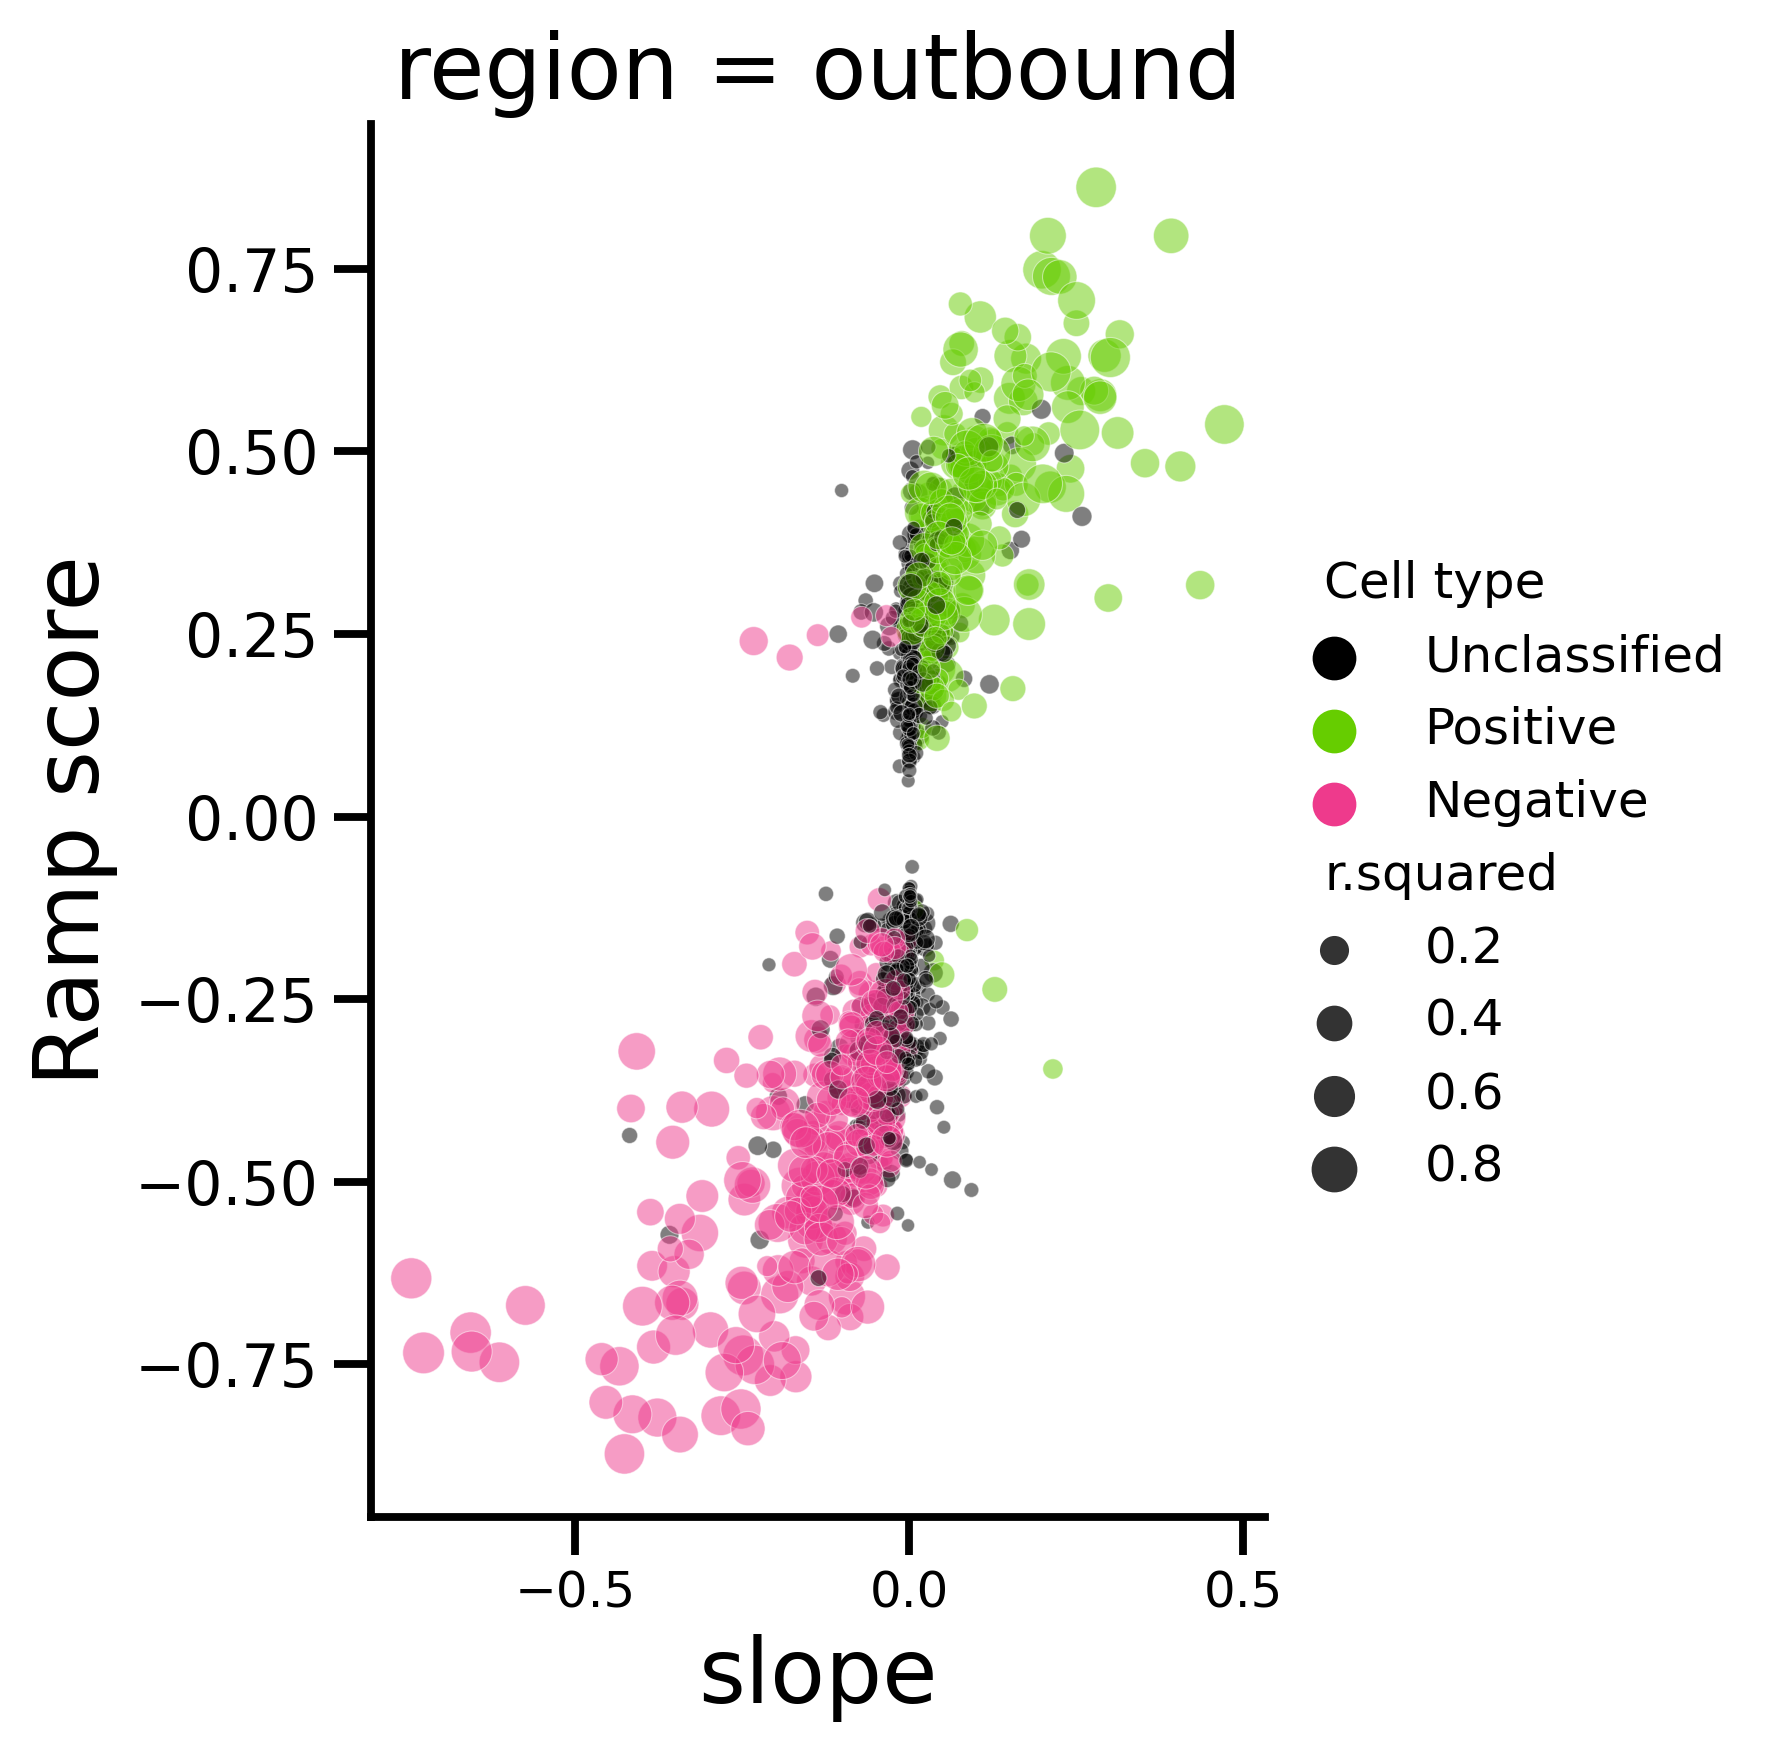

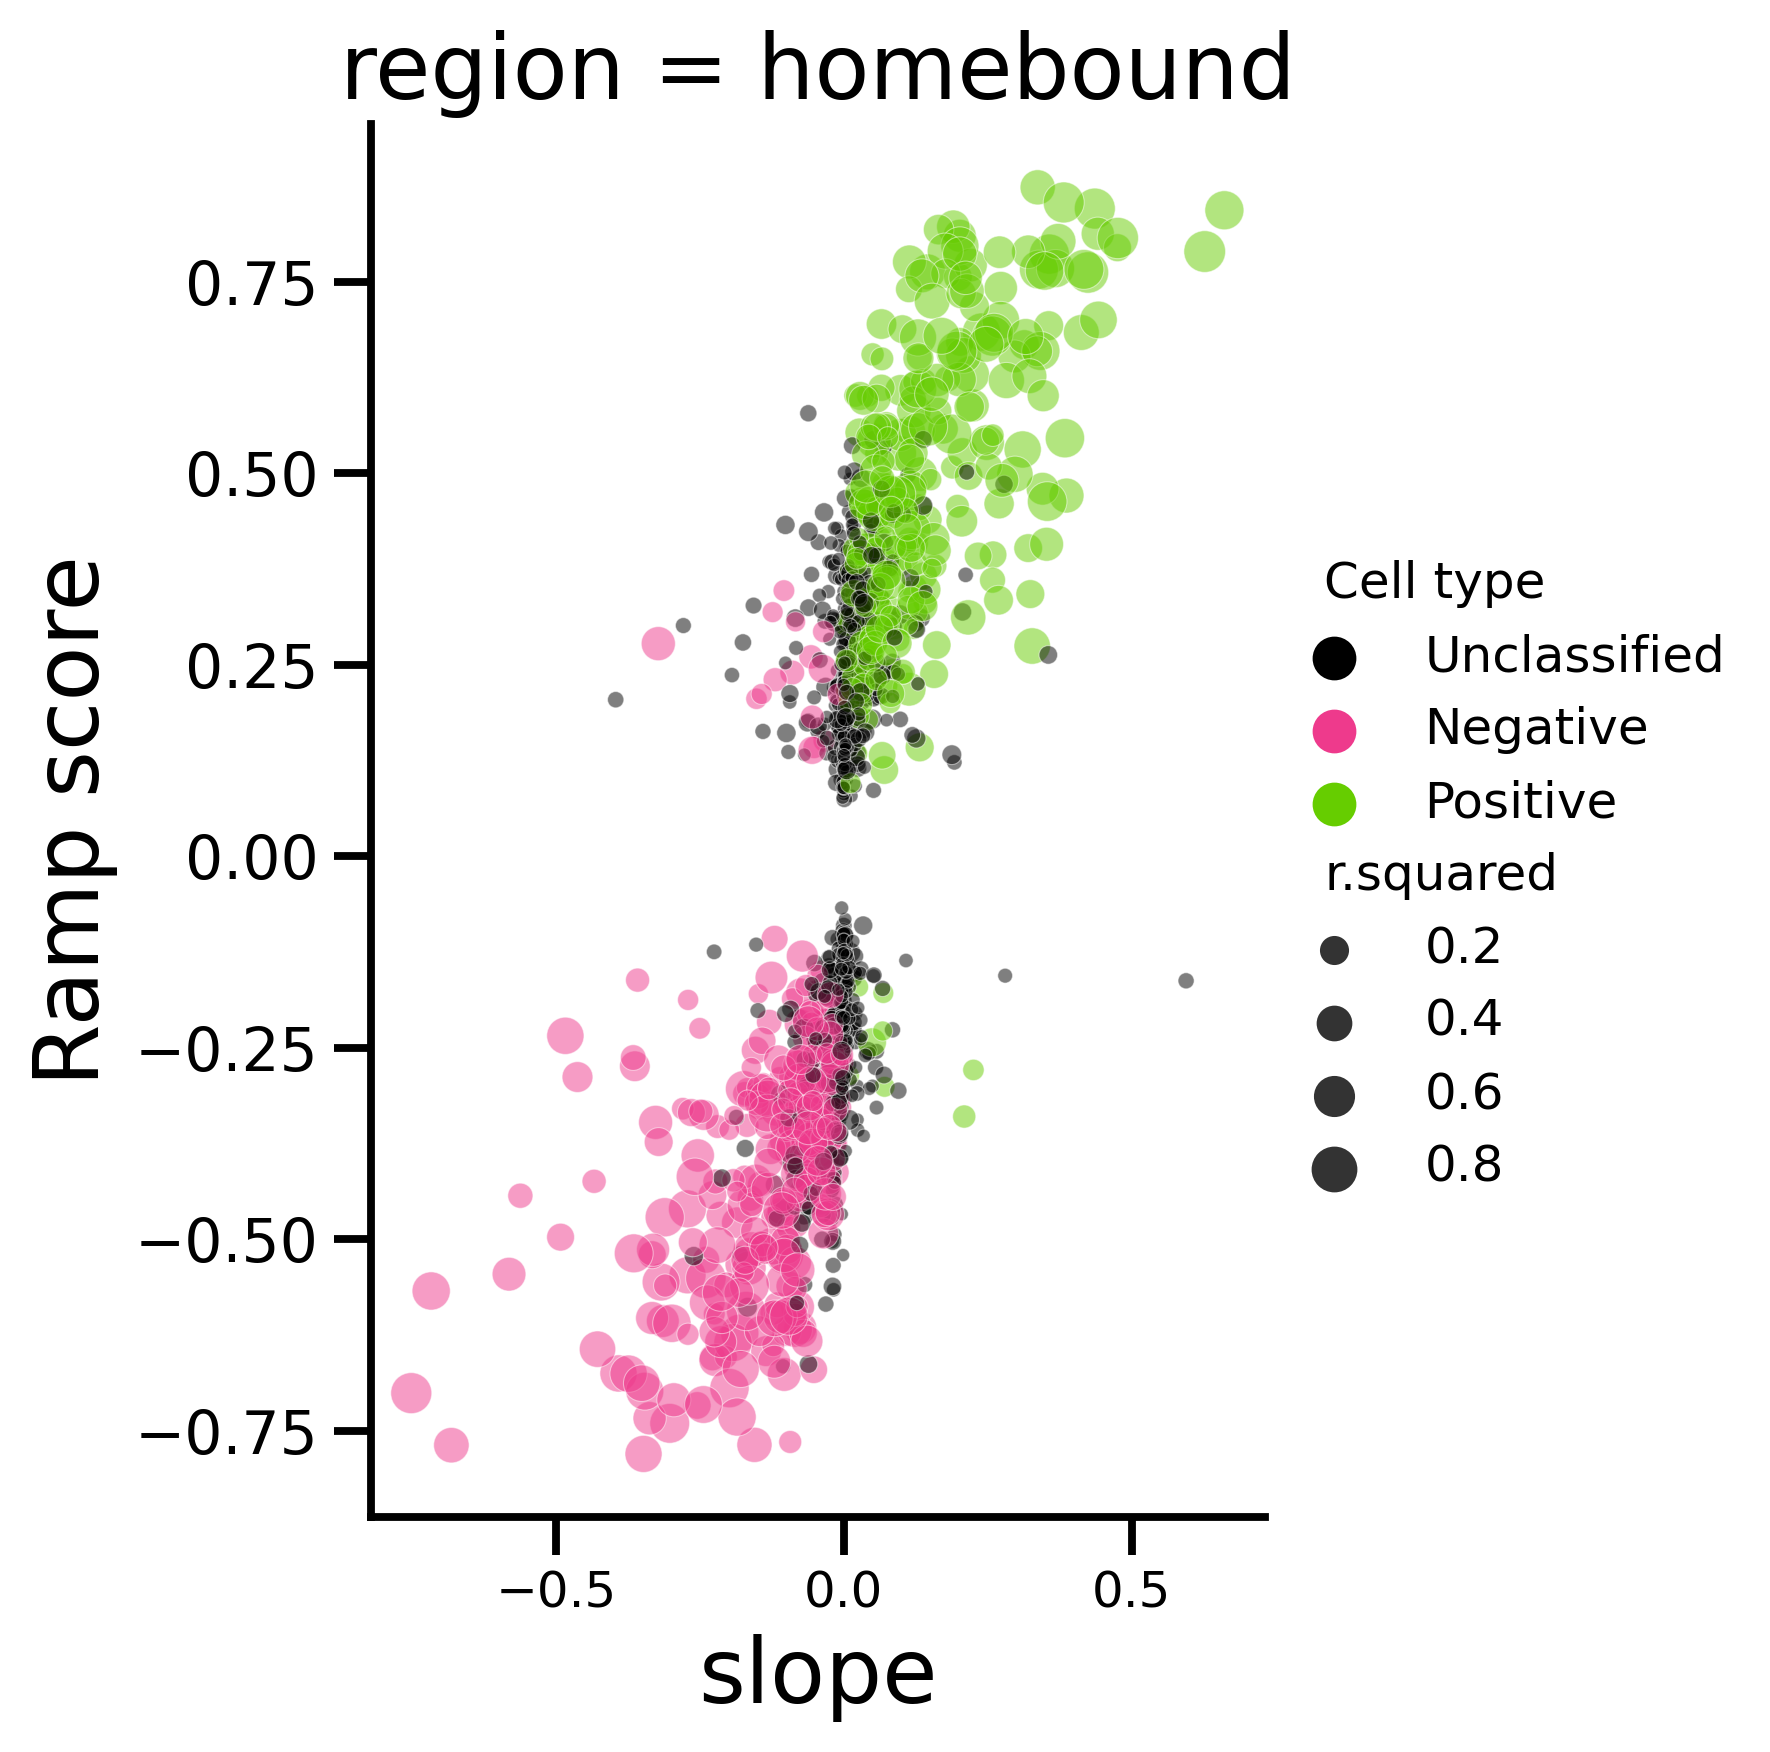

In [11]:
dfs_agg = df_all.copy()
df2plot = dfs_agg[(dfs_agg.region=='outbound') & (dfs_agg.trial_type=='beaconed')]
# assert len(df2plot) == 608

params = {
    'font.size' : 12,
    'figure.dpi':300,
    'axes.titlesize': 'large',
    'xtick.labelsize': 'medium',
    'ytick.labelsize':'large',
    'legend.title_fontsize': 'medium',
    'legend.fontsize':'medium',
}


sns.set_context('talk',font_scale=1.2)

plt.rcParams.update(params)

g1 = sns.relplot(x='slope',y='ramp_score', 
            hue = 'classification',
            palette={'Unclassified':'#000000','Negative':'#EE3A8C', 'Positive': '#66CD00'},
            size='r.squared',
            alpha =0.5,
            sizes=(10,100),
            size_norm=(0,0.9),
            row='region',
            aspect =0.8,
            height = 6,
            data=df2plot)

g1._legend.texts[0].set_text('Cell type')
g1.axes[0][0].set(ylabel='Ramp score')
plt.savefig('paper_figures/rampfigure_C_1.pdf')

df2plot = dfs_agg[(dfs_agg.region=='homebound') & (dfs_agg.trial_type=='beaconed')]
g2=sns.relplot(x='slope',y='ramp_score', 
            hue = 'classification',
            alpha = 0.5,
            palette={'Unclassified':'#000000','Negative':'#EE3A8C', 'Positive': '#66CD00'},
            size='r.squared',
            sizes=(10,100),
            size_norm=(0,0.9),
               aspect =0.8,
            height = 6,
            row='region', data=df2plot)
g2._legend.texts[0].set_text('Cell type')
g2.axes[0][0].set(ylabel='Ramp score')
""

plt.savefig('paper_figures/rampfigure_C_2.pdf')

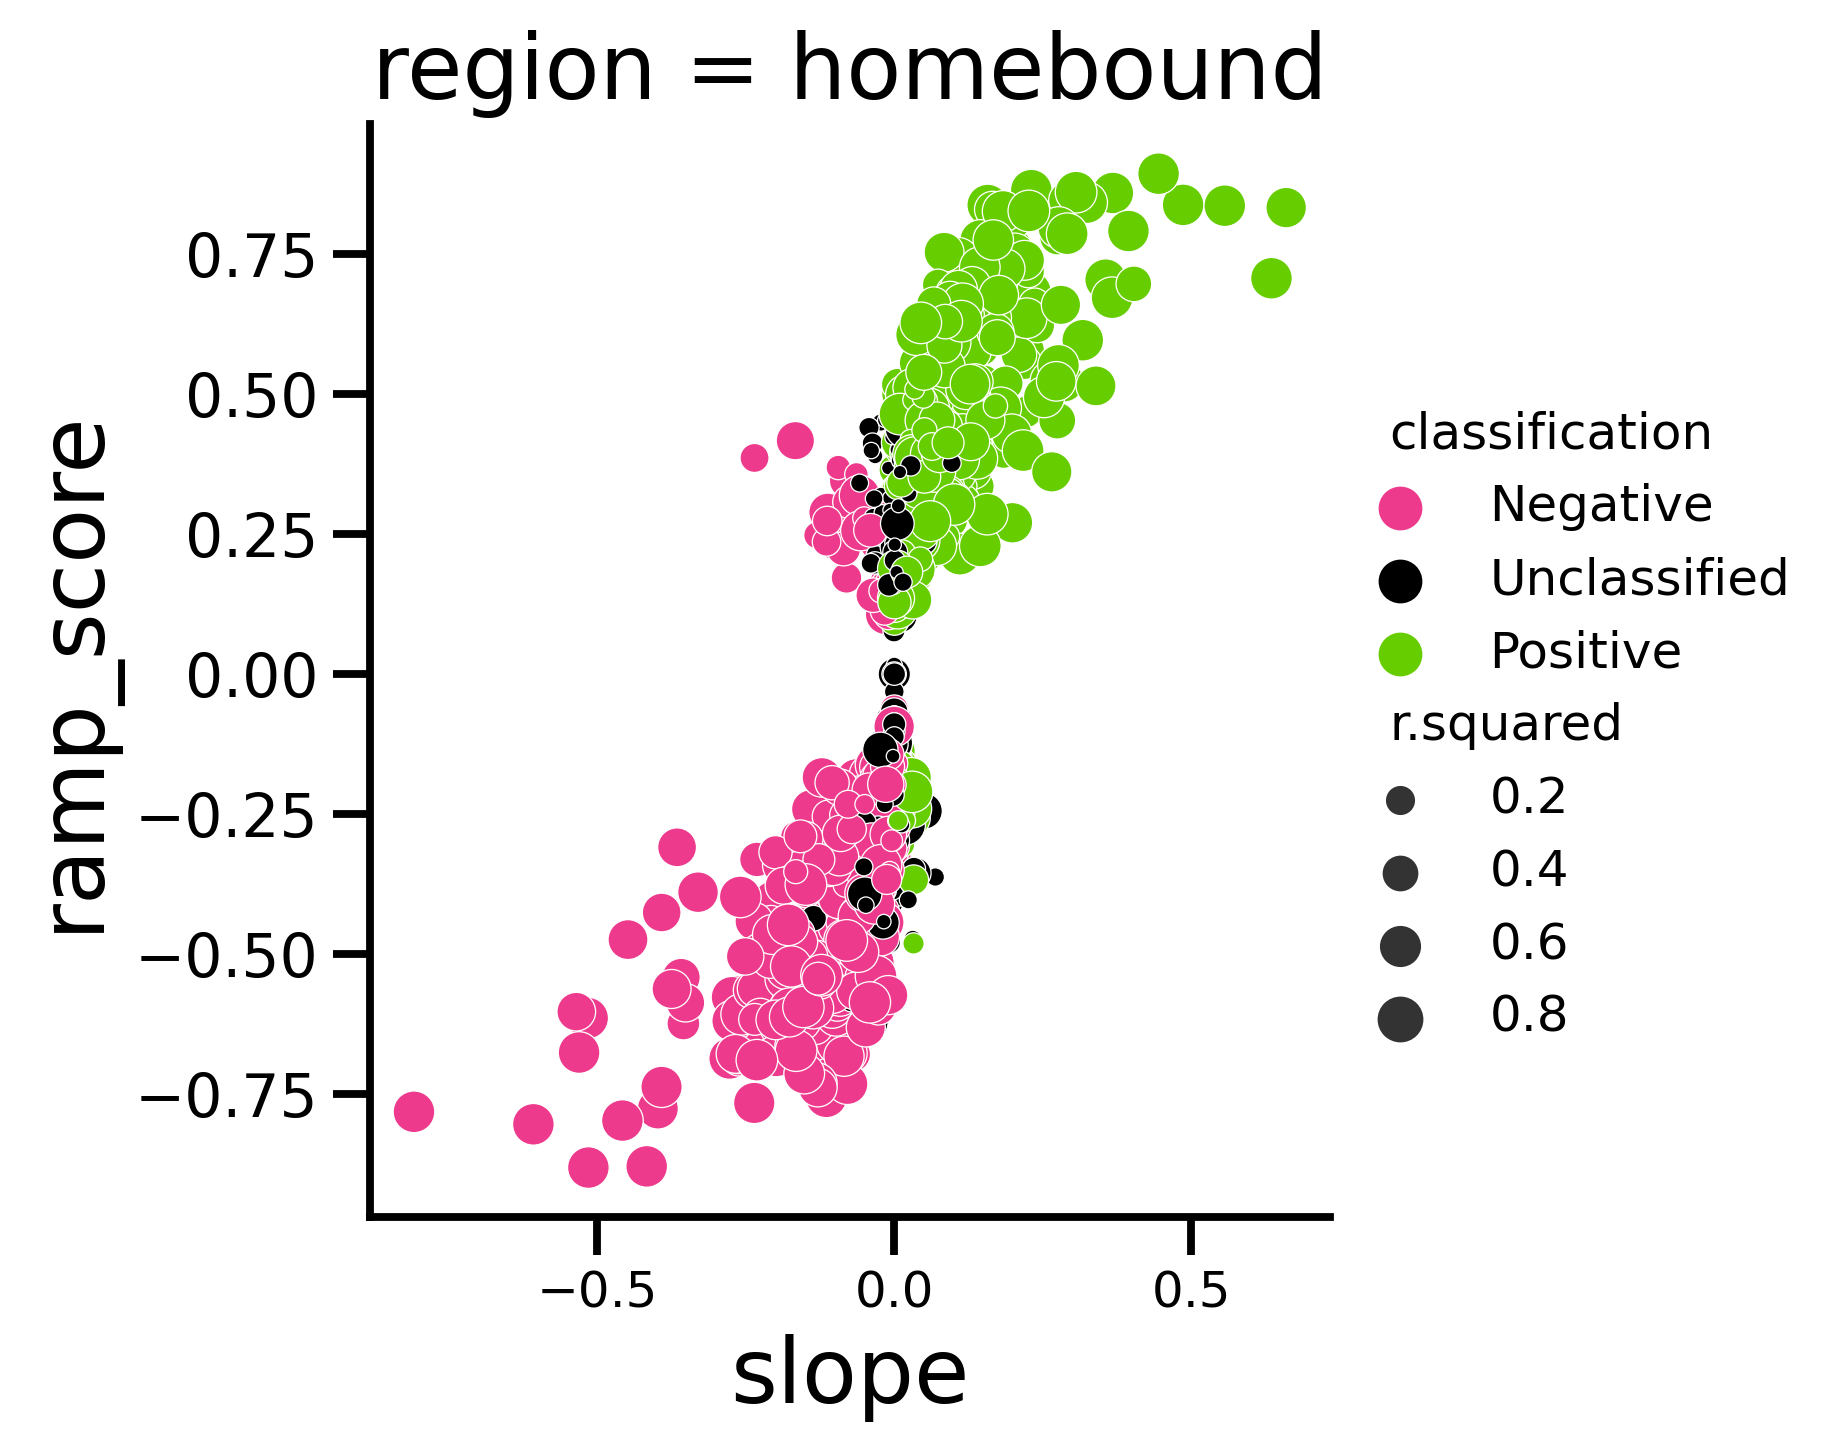

In [10]:
sns.relplot(x='slope',y='ramp_score', 
            hue = 'classification',
            palette={'Unclassified':'#000000','Negative':'#EE3A8C', 'Positive': '#66CD00'},
            size='r.squared',
            sizes=(10,100),
            size_norm=(0,0.9),
            row='region',
            data=df2plot)